<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EXPLORE-DATA" data-toc-modified-id="EXPLORE-DATA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>EXPLORE DATA</a></span></li><li><span><a href="#Load-datasets-and-seperate-into-2-subdatasets" data-toc-modified-id="Load-datasets-and-seperate-into-2-subdatasets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load datasets and seperate into 2 subdatasets</a></span></li><li><span><a href="#Test-data" data-toc-modified-id="Test-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test data</a></span></li><li><span><a href="#Train-valid-split" data-toc-modified-id="Train-valid-split-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train-valid split</a></span></li><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data Augmentation</a></span><ul class="toc-item"><li><span><a href="#Rotation" data-toc-modified-id="Rotation-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Rotation</a></span></li><li><span><a href="#Brightness-Alteration" data-toc-modified-id="Brightness-Alteration-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Brightness Alteration</a></span></li><li><span><a href="#Performing-Horizontal-&amp;-Vertical-shift" data-toc-modified-id="Performing-Horizontal-&amp;-Vertical-shift-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Performing Horizontal &amp; Vertical shift</a></span></li><li><span><a href="#Gaussian-Noise" data-toc-modified-id="Gaussian-Noise-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Gaussian Noise</a></span></li><li><span><a href="#Concatenate-augmentated-data-with-original-data" data-toc-modified-id="Concatenate-augmentated-data-with-original-data-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Concatenate augmentated data with original data</a></span></li></ul></li><li><span><a href="#Create-FaceKeypointsDataset" data-toc-modified-id="Create-FaceKeypointsDataset-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Create FaceKeypointsDataset</a></span></li><li><span><a href="#Training-and-predict-functions" data-toc-modified-id="Training-and-predict-functions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Training and predict functions</a></span></li><li><span><a href="#Model:-Resnet34" data-toc-modified-id="Model:-Resnet34-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Model: Resnet34</a></span><ul class="toc-item"><li><span><a href="#Try-a-one-cycle-training-to-check-the-network-is-valid" data-toc-modified-id="Try-a-one-cycle-training-to-check-the-network-is-valid-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Try a one cycle training to check the network is valid</a></span></li></ul></li><li><span><a href="#L-model" data-toc-modified-id="L-model-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>L model</a></span></li><li><span><a href="#S-model" data-toc-modified-id="S-model-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>S model</a></span></li><li><span><a href="#Predictions" data-toc-modified-id="Predictions-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Predictions</a></span><ul class="toc-item"><li><span><a href="#Predictions-from-S_model" data-toc-modified-id="Predictions-from-S_model-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Predictions from S_model</a></span></li><li><span><a href="#Predictions-from-L_model" data-toc-modified-id="Predictions-from-L_model-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Predictions from L_model</a></span></li><li><span><a href="#Combine-S-and-L-models" data-toc-modified-id="Combine-S-and-L-models-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>Combine S and L models</a></span></li></ul></li></ul></div>

## EXPLORE DATA

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
from math import sin, cos, pi
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils, models
from torchvision.models.resnet import BasicBlock
from torch import nn, optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

IMG_SIZE = 96

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
data_dir = Path('./data')
train_data = pd.read_csv(data_dir / 'training.csv')

In [4]:
def show_keypoints(image, keypoints):
    '''
    Show image with keypoints
    Args:
        image (array-like or PIL image): The image data. (M, N)
        keypoints (array-like): The keypoits data. (N, 2)
    '''
      
    plt.imshow(image, cmap='gray')
    if len(keypoints):
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=24, marker ='.', c='r')

def show_images(df, indxs, ncols=5, figsize=(15,10), with_keypoints=True):
    '''
    Show images with keypoints in grids
    Args:
        df (DataFrame): data (M x N)
        idxs (iterators): list, Range, Indexes
        ncols (integer): number of columns (images by rows)
        figsize (float, float): width, height in inches
        with_keypoints (boolean): True if show image with keypoints
    '''
    plt.figure(figsize=figsize)
    nrows = len(indxs) // ncols + 1
    for i, idx in enumerate(indxs):
        image = np.fromstring(df.loc[idx, 'Image'], sep=' ').astype(np.float32).reshape(-1, IMG_SIZE)
        if with_keypoints:
            keypoints = df.loc[idx].drop('Image').values.astype(np.float32).reshape(-1, 2)
        else:
            keypoints = []
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f'Sample #{idx}')
        plt.axis('off')
        plt.tight_layout()
        show_keypoints(image, keypoints)
    plt.show()

## Load datasets and seperate into 2 subdatasets
- We notice that some images onyl have 4 labeled keypoints (small df) while other images have 11 labeled keypoints (larger df), so we seperate the dataframe into 2 sub dataframes.

In [5]:
train_data = pd.read_csv(data_dir / 'training.csv')

In [6]:
datasets = {'L': ['left_eye_center_x', 'left_eye_center_y',
                  'right_eye_center_x','right_eye_center_y',
                  'nose_tip_x', 'nose_tip_y',
                  'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y',
                  'Image'
                 ], 
            'S': ['left_eye_inner_corner_x','left_eye_inner_corner_y', 
                  'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 
                  'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 
                  'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 
                  'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 
                  'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 
                  'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 
                  'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
                  'mouth_left_corner_x', 'mouth_left_corner_y', 
                  'mouth_right_corner_x', 'mouth_right_corner_y', 
                  'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
                  'Image'
                 ]
           }

In [7]:
S_df = train_data[datasets["S"]].dropna()
S_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2283
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_inner_corner_x    2155 non-null   float64
 1   left_eye_inner_corner_y    2155 non-null   float64
 2   left_eye_outer_corner_x    2155 non-null   float64
 3   left_eye_outer_corner_y    2155 non-null   float64
 4   right_eye_inner_corner_x   2155 non-null   float64
 5   right_eye_inner_corner_y   2155 non-null   float64
 6   right_eye_outer_corner_x   2155 non-null   float64
 7   right_eye_outer_corner_y   2155 non-null   float64
 8   left_eyebrow_inner_end_x   2155 non-null   float64
 9   left_eyebrow_inner_end_y   2155 non-null   float64
 10  left_eyebrow_outer_end_x   2155 non-null   float64
 11  left_eyebrow_outer_end_y   2155 non-null   float64
 12  right_eyebrow_inner_end_x  2155 non-null   float64
 13  right_eyebrow_inner_end_y  2155 non-null   float

In [8]:
L_df = train_data[datasets["L"]].dropna()
L_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 7048
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7000 non-null   float64
 1   left_eye_center_y          7000 non-null   float64
 2   right_eye_center_x         7000 non-null   float64
 3   right_eye_center_y         7000 non-null   float64
 4   nose_tip_x                 7000 non-null   float64
 5   nose_tip_y                 7000 non-null   float64
 6   mouth_center_bottom_lip_x  7000 non-null   float64
 7   mouth_center_bottom_lip_y  7000 non-null   float64
 8   Image                      7000 non-null   object 
dtypes: float64(8), object(1)
memory usage: 546.9+ KB


## Test data

In [9]:
test_data = pd.read_csv('./data/test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


 ## Train-valid split

In [10]:
def load_images_keypoints(dataframe):
    images = []
    keypoints = []
    for i in range(dataframe.shape[0]):
        image = np.fromstring(dataframe.iloc[i, -1], sep=' ')\
                .astype(np.float32).reshape(-1, IMG_SIZE)
        keypoint = dataframe.iloc[i, :-1].values.astype(np.float32)
        images.append(image)
        keypoints.append(keypoint)
    return np.array(images), np.array(keypoints)


In [11]:
S_images,S_keypoints = load_images_keypoints(S_df)

In [12]:
S_images.shape

(2155, 96, 96)

In [13]:
S_keypoints.shape

(2155, 22)

In [14]:
L_images,L_keypoints = load_images_keypoints(L_df)

In [15]:
L_images.shape

(7000, 96, 96)

In [16]:
L_keypoints.shape

(7000, 8)

In [17]:
def plot_sample(image, keypoint, axis, title=None):
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='.', s=20, color='red')
    axis.set_title(title)

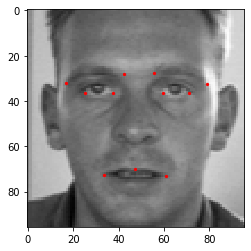

In [18]:
fig, axis = plt.subplots()
plot_sample(S_images[2], S_keypoints[2], axis, title=None)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
S_images_train, S_images_val, S_keypoints_train, S_keypoints_val = train_test_split(S_images, S_keypoints, test_size=0.2, random_state=42)

In [21]:
L_images_train, L_images_val, L_keypoints_train, L_keypoints_val = train_test_split(L_images, L_keypoints, test_size=0.2, random_state=42)

In [22]:
L_images_train.shape

(5600, 96, 96)

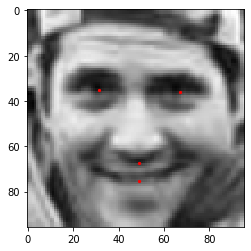

In [23]:
fig, axis = plt.subplots()
plot_sample(L_images_train[20], L_keypoints_train[20], axis, title=None)

## Data Augmentation

### Rotation

In [24]:
def rotate_augmentation_random(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    for i in range(images.shape[0]):
        image = images[i]
        angles = np.random.choice(np.arange(-10,10),3, False) # 30 degree as a limit of rotation
        for angle in angles:
            M = cv2.getRotationMatrix2D((IMG_SIZE//2,IMG_SIZE//2), angle, 1.0)
            angle_rad = angle*pi/180.
            rotated_image = cv2.warpAffine(image, M, (IMG_SIZE,IMG_SIZE), flags=cv2.INTER_CUBIC)
            rotated_images.append(rotated_image)
            # For train_keypoints
            keypoint = keypoints[i]
            rotated_keypoint = keypoint - IMG_SIZE/2    # Subtract the middle value of the image dimension
            for idx in range(0,len(rotated_keypoint),2):
                # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                rotated_keypoint[idx],rotated_keypoint[idx+1] = rotated_keypoint[idx]*cos(angle_rad)+rotated_keypoint[idx+1]*sin(angle_rad),-1*(rotated_keypoint[idx]*sin(angle_rad)-rotated_keypoint[idx+1]*cos(angle_rad))
            rotated_keypoint += IMG_SIZE/2   # Add the earlier subtracted value
            rotated_keypoints.append(rotated_keypoint)

    return np.reshape(rotated_images,(-1,IMG_SIZE,IMG_SIZE)), rotated_keypoints

In [25]:
rotated_S_images_train, rotated_S_keypoints_train = rotate_augmentation_random(S_images_train,S_keypoints_train)

In [26]:
rotated_S_images_train.shape

(5172, 96, 96)

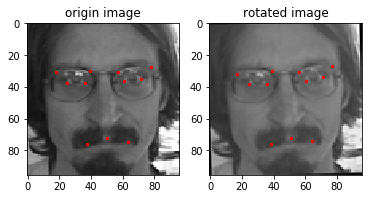

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2)
# idx=90
# plot_sample(train_images[idx], train_keypoints[idx], ax1, title='origin image')
# plot_sample(rotated_images[idx+298], rotated_keypoints[idx+298], ax2, title='rotated image')
# fig, (ax1, ax2) = plt.subplots(1, 2)
idx=10
plot_sample(S_images_train[idx], S_keypoints_train[idx], ax1, title='origin image')
plot_sample(rotated_S_images_train[3*idx+1], rotated_S_keypoints_train[3*idx+1], ax2, title='rotated image')


In [28]:
rotated_L_images_train, rotated_L_keypoints_train = rotate_augmentation_random(L_images_train,L_keypoints_train)

### Brightness Alteration 

In [29]:
def alter_brightness(images, keypoints):
    inc_brightness_images = []
    dec_brightness_images = []
    for image in images:
        increase = np.random.uniform(1.2,1.8)  # limit of brightness increase
        decrease = np.random.uniform(0.5,0.8)  # limit of brightness decrease
        inc_brightness_image = np.clip(image*increase, 0.0, 255.)    
        dec_brightness_image = np.clip(image*decrease, 0.0, 255.) 
        inc_brightness_images.append(inc_brightness_image)
        dec_brightness_images.append(dec_brightness_image)
    return np.concatenate((inc_brightness_images,dec_brightness_images)), np.concatenate((keypoints, keypoints))


In [30]:
altered_brightness_S_images_train, altered_brightness_S_keypoints_train = alter_brightness(S_images_train,S_keypoints_train)

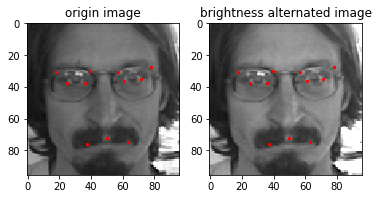

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2)
idx=10
plot_sample(S_images_train[idx], S_keypoints_train[idx], ax1, title='origin image')
plot_sample(altered_brightness_S_images_train[idx], altered_brightness_S_keypoints_train[idx], ax2, title='brightness alternated image')

In [32]:
altered_brightness_L_images_train, altered_brightness_L_keypoints_train = alter_brightness(L_images_train,L_keypoints_train)

### Performing Horizontal & Vertical shift

In [33]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []           
    for image, keypoint in zip(images, keypoints):
        pixel_shifts = np.random.choice(np.arange(2,12),1,False) # limit of shift
        for shift in pixel_shifts:    # Augmenting over several pixel shift values
            for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
                M = np.float32([[1,0,shift_x],[0,1,shift_y]])
                shifted_image = cv2.warpAffine(image, M, (IMG_SIZE,IMG_SIZE), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<IMG_SIZE*1.0):
                    shifted_images.append(shifted_image.reshape(IMG_SIZE,IMG_SIZE))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,IMG_SIZE*1.0)
    return shifted_images, shifted_keypoints

In [34]:
shifted_S_images_train, shifted_S_keypoints_train = shift_images(S_images_train, S_keypoints_train)

In [35]:
len(shifted_S_keypoints_train)

6796

In [36]:
len(shifted_S_images_train)

6796

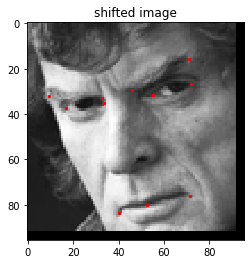

In [37]:
fig, ax = plt.subplots()
idx=80

plot_sample(shifted_S_images_train[idx], shifted_S_keypoints_train[idx], ax, title='shifted image')

In [38]:
shifted_L_images_train, shifted_L_keypoints_train = shift_images(L_images_train, L_keypoints_train)

### Gaussian Noise

In [39]:
def noisy(images):
    noisy_images = []    
    for image in images:
        row,col= image.shape
        mean = 0
        var = np.random.uniform(1, 100, 1)
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        noisy_images.append(noisy)
    return np.array(noisy_images).astype(np.float32)

In [40]:
noisy_L_images_train = noisy(L_images_train)

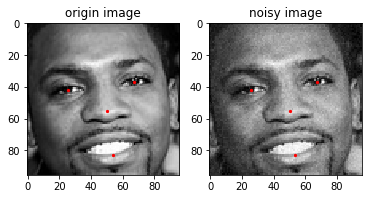

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2)
idx=1000
plot_sample(L_images_train[idx], L_keypoints_train[idx], ax1, title='origin image')
plot_sample(noisy_L_images_train[idx], L_keypoints_train[idx], ax2, title='noisy image')

In [42]:
noisy_S_images_train = noisy(S_images_train)

### Concatenate augmentated data with original data

In [43]:
# concatenate original keypoint data with augmentated keypoint data
L_keypoints_train_aug_total = np.concatenate((L_keypoints_train,
                                              rotated_L_keypoints_train,
                                              altered_brightness_L_keypoints_train,
                                              shifted_L_keypoints_train,
                                              L_keypoints_train
                                             ))
L_keypoints_train_aug_total.shape

(61069, 8)

In [44]:
# concatenate original image data with augmentated image data
L_images_train_aug_total = np.concatenate((L_images_train,
                                           rotated_L_images_train,
                                           altered_brightness_L_images_train,
                                           shifted_L_images_train,
                                           noisy_L_images_train
                                          ))
L_images_train_aug_total.shape

(61069, 96, 96)

In [45]:
# remove keypoints out of range during augmentation
L_keypoints_train_aug=[]
L_images_train_aug=[]
for idx,keypoint in enumerate(L_keypoints_train_aug_total):
    if (keypoint<0).sum() or (keypoint>IMG_SIZE).sum():
        continue
    else:
        L_keypoints_train_aug.append(keypoint)
        L_images_train_aug.append(L_images_train_aug_total[idx])

In [46]:
L_images_train_aug = np.array(L_images_train_aug)
L_images_train_aug.shape

(61069, 96, 96)

In [47]:
L_keypoints_train_aug = np.array(L_keypoints_train_aug)
L_keypoints_train_aug.shape

(61069, 8)

In [48]:
S_keypoints_train_aug_total = np.concatenate((S_keypoints_train,
                                              rotated_S_keypoints_train,
                                              altered_brightness_S_keypoints_train,
                                              shifted_S_keypoints_train,
                                              S_keypoints_train
                                             ))
S_keypoints_train_aug_total.shape

(18864, 22)

In [49]:
S_images_train_aug_total = np.concatenate((S_images_train,
                                           rotated_S_images_train,
                                           altered_brightness_S_images_train,
                                           shifted_S_images_train,
                                           noisy_S_images_train
                                          ))
S_images_train_aug_total.shape

(18864, 96, 96)

In [50]:
# remove keypoints out of range during augmentation
S_keypoints_train_aug=[]
S_images_train_aug=[]
for idx,keypoint in enumerate(S_keypoints_train_aug_total):
    if (keypoint<0).sum() or (keypoint>IMG_SIZE).sum():
        continue
    else:
        S_keypoints_train_aug.append(keypoint)
        S_images_train_aug.append(S_images_train_aug_total[idx])


In [51]:
S_images_train_aug = np.array(S_images_train_aug)
S_images_train_aug.shape

(18860, 96, 96)

In [52]:
S_keypoints_train_aug = np.array(S_keypoints_train_aug)
S_keypoints_train_aug.shape

(18860, 22)

## Create FaceKeypointsDataset
Create FaceKeypointsDataset as a subclass of torch.utils.data.Dataset and override __len__ method to support len(dataset) and __getitem__ method to support dataset[i] for data interation which's not stored all data in memory at once but read as required.

Sample of our dataset will be a dict {'image': image, 'keypoints': keypoints}. Our dataset will take an optional argument transform so that any required processing can be applied on the sample.

In [53]:
class KeypointsDataset(Dataset):
    '''Keypoints Dataset'''
    
    def __init__(self, train_images, train_keypoints, train=True, transform=None):
        '''
        Args:
            dataframe (DataFrame): data in pandas dataframe format.
            train (Boolean) : True for train data with keypoints, default is True
            transform (callable, optional): Optional transform to be applied on 
            sample
        '''
        self.train_images = train_images
        self.train_keypoints = train_keypoints
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.train_images)
    
    def __getitem__(self, idx):

        image = self.train_images[idx]
        
        if self.train:
            keypoints = self.train_keypoints[idx].astype(np.float32)
        else:
            keypoints = None

        sample = {'image': image, 'keypoints': keypoints}
        
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

class Normalize(object):
    '''Normalize input images'''
    
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        return {'image': image / 255., # scale to [0, 1]
                'keypoints': keypoints}
        
class ToTensor(object):
    '''Convert ndarrays in sample to Tensors.'''

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        image = torch.from_numpy(image)
        image = torch.cat([image,image,image],0)
        
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image, 'keypoints': keypoints}

class Resnet_normalize(object):
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        normalize = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        image = normalize(image)
        
        if keypoints is not None:
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}

In [54]:
batch_size=800
tsfm = transforms.Compose([Normalize(), ToTensor(),Resnet_normalize()])

In [55]:
# propare S trainset
S_trainset = KeypointsDataset(S_images_train_aug, S_keypoints_train_aug, transform=tsfm)
S_train_loader = torch.utils.data.DataLoader(S_trainset, batch_size=batch_size, shuffle=True, num_workers=4)

# propare S validset
S_validset = KeypointsDataset(S_images_val, S_keypoints_val, transform=tsfm)
S_valid_loader = torch.utils.data.DataLoader(S_validset, batch_size=batch_size, num_workers=4)



In [56]:
# propare L trainset
L_trainset = KeypointsDataset(L_images_train_aug, L_keypoints_train_aug, transform=tsfm)
L_train_loader = torch.utils.data.DataLoader(L_trainset, batch_size=batch_size, shuffle=True, num_workers=4)

# propare L validset
L_validset = KeypointsDataset(L_images_val, L_keypoints_val, transform=tsfm)
L_valid_loader = torch.utils.data.DataLoader(L_validset, batch_size=batch_size, num_workers=4)



In [57]:
# propare testset
test_images,test_keypoints = load_images_keypoints(test_data)
testset = KeypointsDataset(test_images, test_keypoints, train=False, transform=tsfm)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=4)

In [58]:
len(test_loader)

3

In [59]:
len(S_valid_loader)

1

In [60]:
len(S_train_loader)

24

In [61]:
S_train_loader.dataset[0]['image'].shape

torch.Size([3, 96, 96])

In [62]:
len(L_valid_loader)

2

In [63]:
len(L_train_loader)

77

In [64]:
L_train_loader.dataset[0]['image'].shape

torch.Size([3, 96, 96])

## Training and predict functions

In [65]:
def train(train_loader, valid_loader, model, criterion, lr, 
          n_epochs=50, saved_model='model.pt'):
    '''
    Train the model
    
    Args:
        train_loader (DataLoader): DataLoader for train Dataset
        valid_loader (DataLoader): DataLoader for valid Dataset
        model (nn.Module): model to be trained on
        criterion (torch.nn): loss funtion
        optimizer (torch.optim): optimization algorithms
        n_epochs (int): number of epochs to train the model
        saved_model (str): file path for saving model
    
    Return:
        tuple of train_losses, valid_losses
    '''
    
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    model.train()

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*batch['image'].size(0)

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # update running validation loss 
            valid_loss += loss.item()*batch['image'].size(0)

        # print training/validation statistics 
        # calculate average Root Mean Square loss over an epoch
        train_loss = np.sqrt(train_loss/len(train_loader.dataset))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.dataset))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses  

    
def predict(data_loader, model):
    '''
    Predict keypoints
    Args:
        data_loader (DataLoader): DataLoader for Dataset
        model (nn.Module): trained model for prediction.
    Return:
        predictions (array-like): keypoints in float (no. of images x keypoints).
    '''
    
    model.eval() # prep model for evaluation

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))
    
    return predictions

## Model: Resnet34

In [66]:
class MyResnet2(models.ResNet):
    def __init__(self, block, layers, num_classes=1000, outputs=8):
        super(MyResnet2, self).__init__(block, layers, num_classes)
        self.fc = nn.Linear(IMG_SIZE*IMG_SIZE//2 * block.expansion, outputs)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)


        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

### Try a one cycle training to check the network is valid

In [167]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet34(pretrained=True)


In [168]:

model = MyResnet2(BasicBlock, [3, 4, 6, 3], 1000, outputs=8)

In [169]:
model = model.to(device)

In [170]:
# Iterate through the dataloader once
batch = next(iter(L_train_loader))
inputs = batch['image'].cuda()

In [171]:
outputs = model(inputs)
outputs.size()

torch.Size([800, 8])

In [172]:
batch['keypoints'].shape

torch.Size([800, 8])

In [173]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss = 0.0
optimizer.zero_grad()
# forward pass: compute predicted outputs by passing inputs to the model
output = model(batch['image'].to(device))
# calculate the loss
loss = criterion(output, batch['keypoints'].to(device))
# backward pass: compute gradient of the loss with respect to model parameters
loss.backward()
# perform a single optimization step (parameter update)
optimizer.step()
# update running training loss
train_loss += loss.item()*batch['image'].size(0)

In [174]:
train_loss

2308616.2109375

## L model

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet34(pretrained=True)
model = MyResnet2(BasicBlock, [3, 4, 6, 3], 1000, outputs=8)
model = model.to(device)
criterion = nn.MSELoss()

In [68]:
model_path = Path('./models_dl2020')

In [69]:
L_train_losses, L_valid_losses = train(L_train_loader, L_valid_loader, model, criterion,
                                       lr=0.01, n_epochs=50, saved_model=model_path/'resnet34_L_aug.pt')


Epoch: 1 	Training Loss: 12.246992 	Validation Loss: 4.410362
Validation loss decreased (inf --> 4.410362).  Saving model ...
Epoch: 2 	Training Loss: 4.260291 	Validation Loss: 4.253513
Validation loss decreased (4.410362 --> 4.253513).  Saving model ...
Epoch: 3 	Training Loss: 4.000016 	Validation Loss: 3.926614
Validation loss decreased (4.253513 --> 3.926614).  Saving model ...
Epoch: 4 	Training Loss: 3.691809 	Validation Loss: 3.402907
Validation loss decreased (3.926614 --> 3.402907).  Saving model ...
Epoch: 5 	Training Loss: 3.198175 	Validation Loss: 2.918326
Validation loss decreased (3.402907 --> 2.918326).  Saving model ...
Epoch: 6 	Training Loss: 2.801207 	Validation Loss: 2.519643
Validation loss decreased (2.918326 --> 2.519643).  Saving model ...
Epoch: 7 	Training Loss: 2.530509 	Validation Loss: 2.622542
Epoch: 8 	Training Loss: 2.313370 	Validation Loss: 2.517226
Validation loss decreased (2.519643 --> 2.517226).  Saving model ...
Epoch: 9 	Training Loss: 2.245357

In [70]:
L_train_losses, L_valid_losses = train(L_train_loader, L_valid_loader, model, criterion,
                                       lr=0.001, n_epochs=50, saved_model=model_path/'resnet34_L_aug.pt')


Epoch: 1 	Training Loss: 1.221468 	Validation Loss: 1.993229
Validation loss decreased (inf --> 1.993229).  Saving model ...
Epoch: 2 	Training Loss: 1.037945 	Validation Loss: 1.958906
Validation loss decreased (1.993229 --> 1.958906).  Saving model ...
Epoch: 3 	Training Loss: 1.008858 	Validation Loss: 2.109156
Epoch: 4 	Training Loss: 0.936605 	Validation Loss: 1.975446
Epoch: 5 	Training Loss: 0.867427 	Validation Loss: 1.961534
Epoch: 6 	Training Loss: 0.880843 	Validation Loss: 1.945786
Validation loss decreased (1.958906 --> 1.945786).  Saving model ...
Epoch: 7 	Training Loss: 0.774062 	Validation Loss: 1.927592
Validation loss decreased (1.945786 --> 1.927592).  Saving model ...
Epoch: 8 	Training Loss: 0.875104 	Validation Loss: 2.084209
Epoch: 9 	Training Loss: 0.875013 	Validation Loss: 1.988214
Epoch: 10 	Training Loss: 0.776991 	Validation Loss: 1.896828
Validation loss decreased (1.927592 --> 1.896828).  Saving model ...
Epoch: 11 	Training Loss: 0.754972 	Validation Lo

## S model

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet34(pretrained=True)
model = MyResnet2(BasicBlock, [3, 4, 6, 3], 1000, outputs=22)
model = model.to(device)
criterion = nn.MSELoss()

In [76]:
model_path = Path('./models_dl2020')

In [77]:
S_train_losses, S_valid_losses = train(S_train_loader, S_valid_loader, model, criterion,
                                       lr=0.01, n_epochs=50, saved_model=model_path/'resnet34_S_aug.pt')


Epoch: 1 	Training Loss: 18.069642 	Validation Loss: 38.921687
Validation loss decreased (inf --> 38.921687).  Saving model ...
Epoch: 2 	Training Loss: 5.105685 	Validation Loss: 6.032289
Validation loss decreased (38.921687 --> 6.032289).  Saving model ...
Epoch: 3 	Training Loss: 4.503232 	Validation Loss: 3.681445
Validation loss decreased (6.032289 --> 3.681445).  Saving model ...
Epoch: 4 	Training Loss: 3.911809 	Validation Loss: 3.297498
Validation loss decreased (3.681445 --> 3.297498).  Saving model ...
Epoch: 5 	Training Loss: 3.528181 	Validation Loss: 3.235585
Validation loss decreased (3.297498 --> 3.235585).  Saving model ...
Epoch: 6 	Training Loss: 3.387308 	Validation Loss: 3.334583
Epoch: 7 	Training Loss: 3.324544 	Validation Loss: 3.103952
Validation loss decreased (3.235585 --> 3.103952).  Saving model ...
Epoch: 8 	Training Loss: 3.072394 	Validation Loss: 2.984570
Validation loss decreased (3.103952 --> 2.984570).  Saving model ...
Epoch: 9 	Training Loss: 2.972

In [78]:
S_train_losses, S_valid_losses = train(S_train_loader, S_valid_loader, model, criterion,
                                       lr=0.001, n_epochs=50, saved_model=model_path/'resnet34_S_aug.pt')


Epoch: 1 	Training Loss: 2.386190 	Validation Loss: 1.587867
Validation loss decreased (inf --> 1.587867).  Saving model ...
Epoch: 2 	Training Loss: 1.196633 	Validation Loss: 1.361438
Validation loss decreased (1.587867 --> 1.361438).  Saving model ...
Epoch: 3 	Training Loss: 1.024853 	Validation Loss: 1.281071
Validation loss decreased (1.361438 --> 1.281071).  Saving model ...
Epoch: 4 	Training Loss: 0.952478 	Validation Loss: 1.272359
Validation loss decreased (1.281071 --> 1.272359).  Saving model ...
Epoch: 5 	Training Loss: 0.944125 	Validation Loss: 1.283457
Epoch: 6 	Training Loss: 0.921497 	Validation Loss: 1.303122
Epoch: 7 	Training Loss: 0.925992 	Validation Loss: 1.290434
Epoch: 8 	Training Loss: 0.885950 	Validation Loss: 1.268028
Validation loss decreased (1.272359 --> 1.268028).  Saving model ...
Epoch: 9 	Training Loss: 0.912388 	Validation Loss: 1.298881
Epoch: 10 	Training Loss: 0.886953 	Validation Loss: 1.262926
Validation loss decreased (1.268028 --> 1.262926)

## Predictions

### Predictions from S_model

In [89]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet34(pretrained=True)
model = MyResnet2(BasicBlock, [3, 4, 6, 3], 1000, outputs=22)
model = model.to(device)

model.load_state_dict(torch.load(model_path/'resnet34_S_aug.pt'))

S_predictions = predict(test_loader, model)



In [90]:
S_predictions.shape

(1783, 22)

In [91]:
def view_pred_df(columns, test_df, predictions, image_ids=range(1,6)):
    '''
    Display predicted keypoints
    Args:
        columns (array-like): column names
        test_df (DataFrame): dataframe with ImageId and Image columns
        predictions (array-like): keypoints in float (no. of images x keypoints)
        image_id (array-like): list or range of ImageIds begin at 1
    '''
    pred_df = pd.DataFrame(predictions, columns=columns)
    pred_df = pd.concat([pred_df, test_df], axis=1)
    pred_df = pred_df.set_index('ImageId')
    show_images(pred_df, image_ids)  # ImageId as index begin at 1

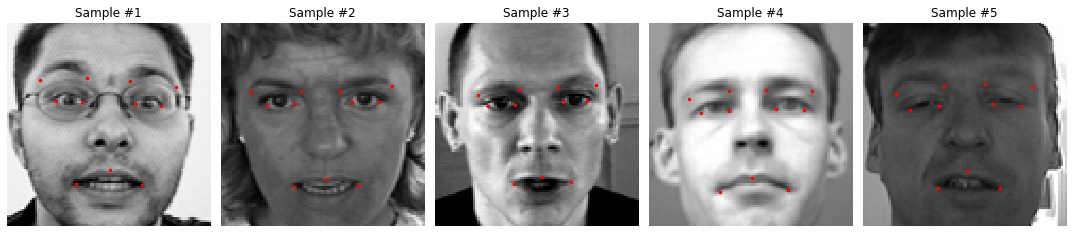

In [92]:
S_columns = S_df.drop('Image', axis=1).columns

view_pred_df(S_columns, test_data, S_predictions)


### Predictions from L_model

In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet34(pretrained=True)
model = MyResnet2(BasicBlock, [3, 4, 6, 3], 1000, outputs=8)
model = model.to(device)
model.load_state_dict(torch.load(model_path/'resnet34_L_aug.pt'))
L_predictions = predict(test_loader, model)


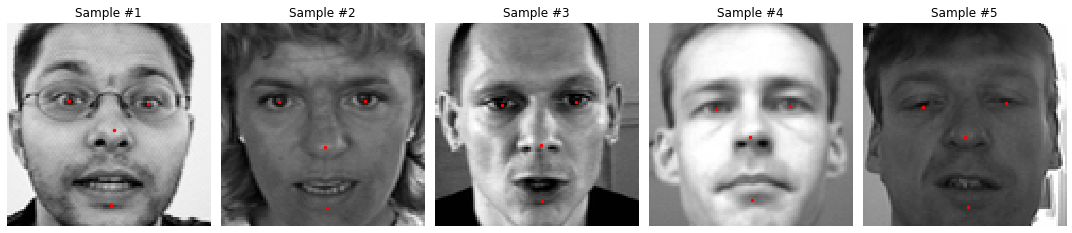

In [94]:
L_columns = L_df.drop('Image', axis=1).columns

view_pred_df(L_columns, test_data, L_predictions)


### Combine S and L models

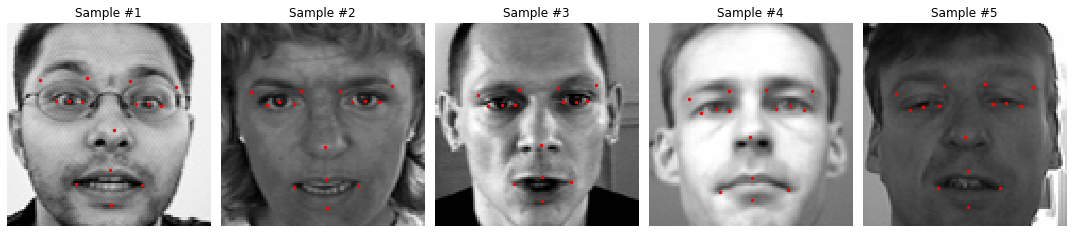

In [96]:
predictions = np.hstack((L_predictions, S_predictions))
columns = list(L_columns) + list(S_columns)
view_pred_df(columns, test_data, predictions)

In [98]:
def create_submission(predictions, pred_file='data/preds.csv', sub_file='data/submission.csv', columns=None):
    '''
    Create csv file for submission from predictions
    Args:
        predictions (array-like): prediction (no. fo images x 30 keypoints)
        pred_file (string): file path for prediction csv file
        sub_file (string): file path for submission csv file
        columns (dict): provided column names for submission file
    '''
    lookup = pd.read_csv('data/IdLookupTable.csv')
    if columns == None:
        columns = train_data.columns[:-1]
    preds = pd.DataFrame(predictions, 
                         index=np.arange(1, len(predictions)+1), 
                         columns=columns)
    preds.to_csv(pred_file)
    locations = [preds.loc[image_id, feature_name] 
                 for image_id, feature_name 
                 in lookup[['ImageId', 'FeatureName']].values]
    locations = [location if location < IMG_SIZE else IMG_SIZE for location in locations]
    lookup.Location = pd.Series(locations)
    lookup[['RowId', 'Location']].to_csv(sub_file, index=False)

In [99]:
create_submission(predictions, 
                  pred_file='data/resnet34_2set_aug_preds.csv', 
                  sub_file='data/resnet34_2set_aug_submission.csv',
                  columns=columns)

In [100]:
# Comment out to submit to Kaggle: private 1.68023 public 1.87465
import os
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""


!kaggle competitions submit -c facial-keypoints-detection -f data/resnet34_2set_aug_submission.csv -m "resnet34_2set_aug"

100%|█████████████████████████████████████████| 628k/628k [00:02<00:00, 271kB/s]
Successfully submitted to Facial Keypoints Detection